In [37]:
import numpy as np
from neural_net import NeuralNet
%load_ext autoreload
%autoreload 2
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [295]:
filename = "toy_multiclass_1"
nn = NeuralNet.fromMAT(filename, type="train", lam=0)

In [296]:
gd = nn.constructGradDescentObject()

In [298]:
print nn.lam
print "shape(T) = " + str(np.shape(nn.T))
print "shape(X) = " + str(np.shape(nn.X))
print "shape(W1) = " + str(np.shape(nn.W1))
print "shape(W2) = " + str(np.shape(nn.W2))

0
shape(T) = (3, 300)
shape(X) = (3, 300)
shape(W1) = (30, 3)
shape(W2) = (3, 31)


In [286]:
nn.forwardProp(nn.X)
print "M = " + str(nn.M)
print "shape(a_hidden) = " + str(np.shape(nn.a_hidden))
print "shape(z) = " + str(np.shape(nn.z))
print "shape(a_outputs) = " + str(np.shape(nn.a_outputs))
print "shape(y) = " + str(np.shape(nn.y))

M = 30
shape(a_hidden) = (30, 300)
shape(z) = (31, 300)
shape(a_outputs) = (3, 300)
shape(y) = (3, 300)


In [299]:
w_list = [np.random.random_sample(np.shape(nn.W1)), np.random.random_sample(np.shape(nn.W2))]
nn.W1 = w_list[0]
nn.W2 = w_list[1]
# nn.forwardProp(nn.X, w_list=w_list)
# nn.computeDeltaOutput(np.arange(0,nn.N))
# print np.shape(nn.deltaOutput)
# print np.shape(nn.W2[:,1:].T)
# nn.backPropFull()
[W1_grad, W2_grad] = nn.evalDerivs(w_list)
print "shape(W1_grad) = " + str(np.shape(W1_grad))
print "shape(W2_grad) = " + str(np.shape(W2_grad))
print "shape(deltaHidden) = " + str(np.shape(nn.deltaHidden))
print "shape(deltaOutput) = " + str(np.shape(nn.deltaOutput))
# t = np.outer(nn.deltaHidden[:,0], nn.X[:,0])
# print np.shape(t)
# s = np.outer(nn.deltaOutput[:,0], nn.z[:,0])
# print np.shape(s)
# print W1_grad
# print W2_grad

shape(W1_grad) = (30, 3)
shape(W2_grad) = (3, 31)
shape(deltaHidden) = (30, 300)
shape(deltaOutput) = (3, 300)


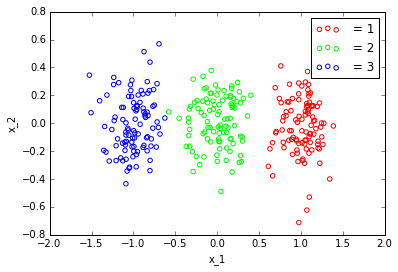

In [300]:
nn.plotData()

function val = -110.764820023
function val after gradient step = -108.67918647
 
--- Minimization Summary --- 
f_min is = -293.794901044
achieved tolerance = -0.00163114807788
numFunctionCalls = 3000
---------------------------- 
 


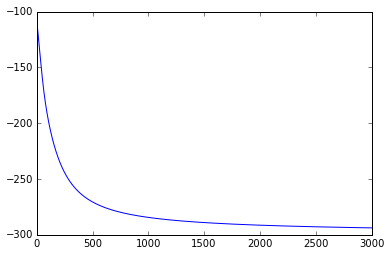

In [302]:
w_initial = [np.random.random_sample(np.shape(nn.W1)), np.random.random_sample(np.shape(nn.W2))]
# w_initial = [nn.W1, nn.W2]
# print w_initial[0]
print "function val = " + str(gd.evalF(w_initial))
gd.stepSize = 0.001
(w_next, f_next) = gd.gradDescentUpdate(w_initial)
print "function val after gradient step = " + str(f_next)
# print nn.evalCost(nn.lam, w_list=w_initial)
w_min, f_min, _, _ = gd.computeMin(w_initial, maxFunctionCalls=3000, storeIterValues=True)
gd.plotIterValues()

[  9.97510662e-01   2.48933779e-03   4.39508822e-12]
(array([0]),)


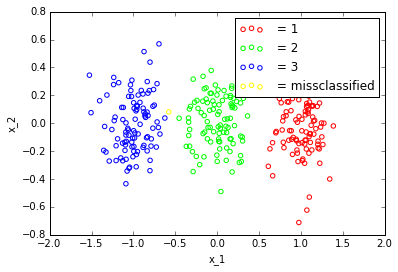

In [303]:
#print w_min
nn.forwardProp(nn.X,w_list=w_min)
print nn.y[:,0]
idx = np.where(nn.y[:,0] == np.max(nn.y[:,0]))
print idx
nn.plotNN(w_min)

## Loss Function

We want to compute the loss function. Using the softmax formulation from Bishop the likelihood is $$\prod_n y_n(x,w)^{t_n}$$. Then we get the log likelihood just by taking logs, then we put a negative sign in front in order to convert it to a minimization problem. Then the loss function is $$-\sum_n t_n \log(y_n(x,w)) + \lambda ||w||_2^2 $$

Activation function is sigmoid

$$ g(z) = \frac{1}{1 + e^{-z}} $$



Each $W^{(1)}$ and $W^{(2)}$ (they call them $w^{(1)}$ and $w^{(2)}$) is a matrix of weights:


$$ W^{(1)} = \begin{bmatrix} w_{1,0} & w_{1,1} & ... & ... & w_{1,D}\\
w_{2,0} &w_{2,1} & ... & ... & w_{2,D} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
w_{M,0} &w_{M,1} & ... & ... & w_{M,D}  \end{bmatrix}$$

$$ W^{(2)} = \begin{bmatrix} w_{1,0} & w_{1,1} & ... & ... & w_{1,M}\\
w_{2,0} &w_{2,1} & ... & ... & w_{2,M} \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
w_{K,0} &w_{K,1} & ... & ... & w_{K,M}  \end{bmatrix}$$


And we assume $M=N/10$ to start, AKA the amount of hidden units we have in our 1 hidden layer is $M$, and we initialize it to $N/10$, where is $N$ is the number of training examples we have

For our toy dataset, we just have $D$ = 2

The loss function is the NLL and is, given training data and parameters $w$:

$$ l(w) = \sum_{i=1}^N \sum_{k=1}^K \big[ -y_k^{(i)} \log (h_k (x^{(i)}. w)) = (1 - y_k^{(i)}) \log(1-(h_k(x^{(i)},w)) \big] $$

But in order to avoid overfitting, we add regularization terms using the Frobenius norm $||A||_F$ and use as our cost function:

$$ J(w) = l(w) + \lambda(||w^{(1)}||^2_F + ||w^{(2)}||^2_F )$$

### Filling in the holes

The homework description is annoyingly a description of what to do but without enough info to be helpful.

What we also need is the activations:

$$ a_j^{(1)} = \sum_{i=1}^d w_{ji}^{(1)}x_i + w_{j0}^{(1)}$$

And use $g$ to calculate the "feature" for each unit:

$$ z_j = g(a_j) $$


To nicely vectorize our computation of the activations $a$, the first step is to augment our input data with a "1" for each training sample, so that we allow for the $M$ bias weights to be included in the matrix:

$$ x_{aug} = \begin{bmatrix} 1_{N \times 1} &| & x\end{bmatrix} $$

We can now nicely vectorize our computation for the activations:
    
$$ a^{(1)} = W^{(1)} x_{aug} $$

Where we note the dimensionality of each: 
- $x_{aug}$ is a vector of dimension $D+1 \times 1$, where $D$ is the dimensionality of the input data
- $W^{(1)}$ is a matrix of dimension $M \times D+1$, where $M$ is the number of hidden units
- $a^{(1)}$ is a vector of dimension $M \times 1$

Also note that $x_{aug}$ is just for one of the training data samples, $n = 1,...,N$

### Implementing backprop

The notes from class are not super clear, but Bishop 5.3 is.

Here's what we'll do:

- Apply an input vector $x_n$ to the network and forward propagate through the network using 5.48 and 5.49 in order to find the activations of all hidden and output units
- Evaluate the $\delta_k$ for all the output units using 5.54
- Backpropagate the $\delta$'s using 5.56 to obtain $\delta_j$ for each hidden unit in the network
- Use 5.53 to evaluate the required derivatives


5.48 (should be implemented as a matrix multiplication as described above): $$a_j = \sum_i w_{ji}z_i$$

5.49 (is already vectorized as long as $h()$ accepts numpy arrays as input: $$z_j = h(a_j)$$

5.54 (can just be implemented as one subtraction of K-dimensional vectors): $$\delta_k = y_k - t_k$$

5.56 for going from output to hidden layer: $$\delta_j = h'(a_j)\sum_k w_{kj} \delta_k$$

Can be vectorized as:

$$\delta_{prev layer} = h'(a_{prev layer}) \ \  .* \ \ W_{no bias weights}^T \delta_{outputs}  $$

Where .* is element-wise multiply, $\delta_{outputs}$ is a $K$-dimensional vector, $W_{no bias weights}^T$ is $M \times K$

5.53: $$ \frac{\partial E_n}{\partial w_{ji}} = \delta_j z_i $$

Which can be vectorized as on outer product:

$$ \frac{\partial E_n}{\partial W} = z \delta^T$$ 



While implementing as a batch method, we finally sum over all input data samples:


$$ \frac{\partial E}{\partial w_{ji}} = \sum_{n} \frac{\partial E_n}{\partial w_{ji}}$$

### Part 1, Gradient Calculation

Calculate analytical expressions for the gradients with respect to the different matrices of weights.

### Part 2, Implement 2-layer neural network

Use the analytic gradient expressions together with your simple gradient descent procedure to train the network.  Remember to do your implementation in sufficient generality so that you can vary the number of nodes in the hidden layer.

### Part 3, Stochastic gradient descent

Make a small change to your code so that it does *stochastic* gradient descent, doing separate updates based on individual training examples.

### Part 4, Test your Neural Network code

Use your neural network code on the 3-class toy data introduced in the previous question.  Use cross-validation to determine the number of hidden nodes necessary for classification.  Compare the results from batch and from stochastic gradient descent.  (Do NOT need to compare with SVM results)

Actual data


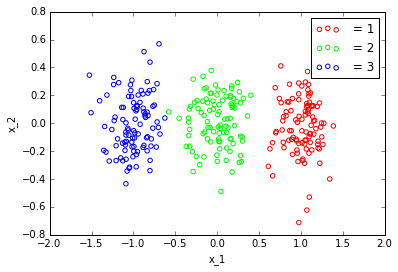

It took 0.181864976883 seconds to plot original data.
 
--- Minimization Summary --- 
f_min is = 32.4035981499
achieved tolerance = -0.00732581085826
numFunctionCalls = 3000
---------------------------- 
 


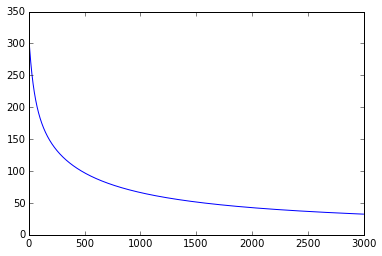

It took 1.94769787788 seconds to train.
Neural net classifier


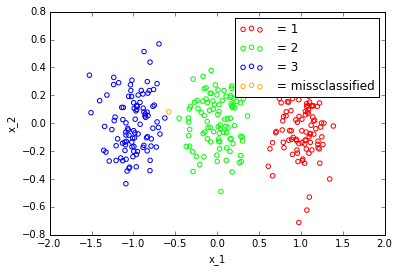

It took 0.18160200119 seconds to plot classification predictions.
number of entries missclassified = 1
missclassification rate  = 0.00333333333333


In [42]:
filename = "toy_multiclass_1"
nn = NeuralNet.fromMAT(filename, type="train", lam=0)
nn.train()

### TEST DATASET ###


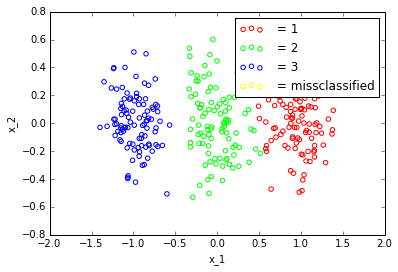

number of entries missclassified = 1
missclassification rate  = 0.00333333333333
It took 0.185726881027 seconds to test.


In [11]:
nn.test()

### VALIDATION DATASET ###


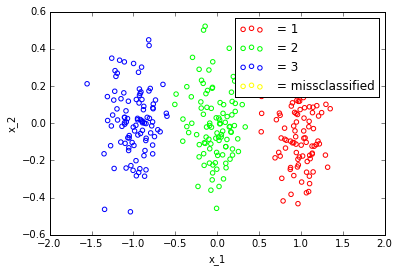

number of entries missclassified = 2
missclassification rate  = 0.00666666666667
It took 0.179266929626 seconds to validate.


In [12]:
nn.validate()

Actual data


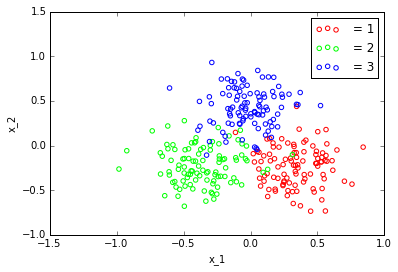

It took 0.153160095215 seconds to plot original data.
 
--- Minimization Summary --- 
f_min is = -240.906350056
achieved tolerance = -0.00711934895733
numFunctionCalls = 3000
---------------------------- 
 


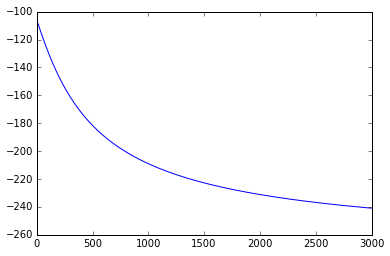

It took 21.7485949993 seconds to train.
Neural net classifier


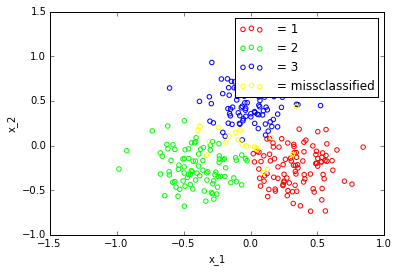

It took 0.166098117828 seconds to plot classification predictions.
number of entries missclassified = 20
missclassification rate  = 0.0666666666667
### TEST DATASET ###


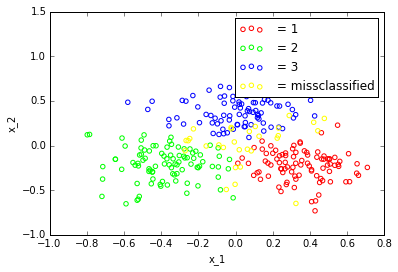

number of entries missclassified = 29
missclassification rate  = 0.0966666666667
It took 0.187349081039 seconds to test.
### VALIDATION DATASET ###


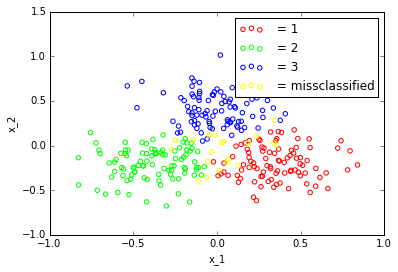

number of entries missclassified = 20
missclassification rate  = 0.0666666666667
It took 0.162427186966 seconds to validate.


In [13]:
filename = "toy_multiclass_2"
nn = NeuralNet.fromMAT(filename, type="train", lam=0)
nn.train()
nn.test()
nn.validate()

In [24]:
M = np.linspace(5,35,7)
print M

trainCER = M * 0.0
testCER = M * 0.0
validateCER = M * 0.0

for i in range(len(M)):
    m = M[i]
    filename = "toy_multiclass_2"
    nn = NeuralNet.fromMAT(filename, type="train", lam=0, M=m)

    nn.train(verbose=False)
    trainCER[i] = nn.missclassifiedRate
    
    nn.test(verbose=False)
    testCER[i] = nn.missclassifiedRate
    
    nn.validate(verbose=False)
    validateCER[i] = nn.missclassifiedRate

[  5.  10.  15.  20.  25.  30.  35.]
 
--- Minimization Summary --- 
f_min is = -196.393834578
achieved tolerance = -0.0126466903064
numFunctionCalls = 3000
---------------------------- 
 
It took 19.5888550282 seconds to train.
number of entries missclassified = 27
missclassification rate  = 0.09
### TEST DATASET ###
number of entries missclassified = 31
missclassification rate  = 0.103333333333
It took 0.00592017173767 seconds to test.
### VALIDATION DATASET ###
number of entries missclassified = 23
missclassification rate  = 0.0766666666667
It took 0.00680112838745 seconds to validate.
 
--- Minimization Summary --- 
f_min is = -217.163127626
achieved tolerance = -0.0111759633901
numFunctionCalls = 3000
---------------------------- 
 
It took 20.3708691597 seconds to train.
number of entries missclassified = 22
missclassification rate  = 0.0733333333333
### TEST DATASET ###
number of entries missclassified = 29
missclassification rate  = 0.0966666666667
It took 0.00252389907837 seco

NameError: name 'plt' is not defined

Training CER vs. M (number of hidden nodes)
Test CER vs. M (number of hidden nodes)
Validation CER vs. M (number of hidden nodes)


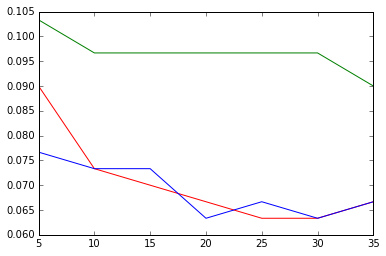

In [30]:
print "Training CER vs. M (number of hidden nodes)"    
plt.plot(M, trainCER, 'red')

print "Test CER vs. M (number of hidden nodes)"    
plt.plot(M, testCER, 'green')

print "Validation CER vs. M (number of hidden nodes)"    
plt.plot(M, validateCER, 'blue')
plt.show()

In [33]:
M = np.linspace(35,65,7)
print M

trainCER = M * 0.0
testCER = M * 0.0
validateCER = M * 0.0

for i in range(len(M)):
    m = M[i]
    filename = "toy_multiclass_2"
    nn = NeuralNet.fromMAT(filename, type="train", lam=0, M=m)

    nn.train(verbose=False)
    trainCER[i] = nn.missclassifiedRate
    
    nn.test(verbose=False)
    testCER[i] = nn.missclassifiedRate
    
    nn.validate(verbose=False)
    validateCER[i] = nn.missclassifiedRate

[ 35.  40.  45.  50.  55.  60.  65.]
It took 21.752477169 seconds to train.
number of entries missclassified = 19
missclassification rate  = 0.0633333333333
### TEST DATASET ###
number of entries missclassified = 29
missclassification rate  = 0.0966666666667
It took 0.00266695022583 seconds to test.
### VALIDATION DATASET ###
number of entries missclassified = 20
missclassification rate  = 0.0666666666667
It took 0.00277209281921 seconds to validate.
It took 22.8987379074 seconds to train.
number of entries missclassified = 20
missclassification rate  = 0.0666666666667
### TEST DATASET ###
number of entries missclassified = 28
missclassification rate  = 0.0933333333333
It took 0.00273990631104 seconds to test.
### VALIDATION DATASET ###
number of entries missclassified = 20
missclassification rate  = 0.0666666666667
It took 0.0028600692749 seconds to validate.
It took 22.9857680798 seconds to train.
number of entries missclassified = 18
missclassification rate  = 0.06
### TEST DATASET 

Training CER vs. M (number of hidden nodes)
Test CER vs. M (number of hidden nodes)
Validation CER vs. M (number of hidden nodes)


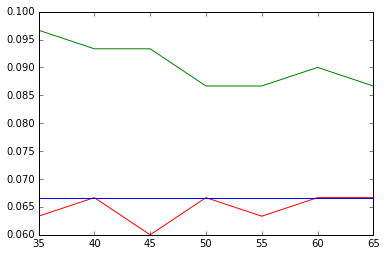

In [34]:
print "Training CER vs. M (number of hidden nodes)"    
plt.plot(M, trainCER, 'red')

print "Test CER vs. M (number of hidden nodes)"    
plt.plot(M, testCER, 'green')

print "Validation CER vs. M (number of hidden nodes)"    
plt.plot(M, validateCER, 'blue')
plt.show()